In [1]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class surface_patch():

    def __init__(self, coords: tuple[int, int]) -> None:
        self.coords = coords

class lattice_surgery_op():
    
    def __init__(self, data_patches: list[surface_patch], active_data_patches: list[surface_patch], routing_patches: list[surface_patch]) -> None:
        self.data_patches = data_patches
        self.active_coords = [patch.coords for patch in active_data_patches + routing_patches]
        self.routing_patches = routing_patches
    
    def gen_subgraph(self, t0: int = 0, delays: int = 0) -> nx.Graph:
        G = nx.Graph()
        for patch in self.data_patches:
            G.add_node(patch.coords + (t0,), data=True)
        for patch in self.routing_patches:
            G.add_node(patch.coords + (t0,), data=False)
            for coords in G.nodes:
                if (coords[0], coords[1]) in self.active_coords and np.linalg.norm(np.array(patch.coords + (t0,)) - np.array(coords)) == 1:
                    G.add_edge(patch.coords + (t0,), coords)
        for t in range(delays):
            for patch in self.data_patches:
                G.add_node(patch.coords + (t0 + t + 1,), data=True)
                G.add_edge(patch.coords + (t0 + t,), patch.coords + (t0 + t + 1,))
        return G



In [3]:
class di_dependency_graph():

    def __init__(self, decoding_graph: nx.Graph, schedule: str) -> None:
        di_dep_graph = decoding_graph.to_directed()
        if schedule == 'sliding':
            for edge in list(di_dep_graph.edges):
                if edge[0][2] > edge[1][2]:
                    di_dep_graph.remove_edge(*edge)
                elif edge[0][2] == edge[1][2] and (edge[1], edge[0]) in di_dep_graph.edges:
                    di_dep_graph.remove_edge(*edge)
        elif schedule == 'parallel':
            uncolored_nodes = list(di_dep_graph.nodes)
            color_queue = [(uncolored_nodes[0], 0)]
            while len(uncolored_nodes) > 0:
                if len(color_queue) == 0:
                    color_queue.append((uncolored_nodes[0], 0))
                curr_node, color = color_queue.pop(0)
                if curr_node not in uncolored_nodes:
                    continue
                neighbors = list(di_dep_graph.neighbors(curr_node))
                color_queue.extend(zip(neighbors, [color ^ 1] * len(neighbors)))
                for edge in list(di_dep_graph.edges(curr_node)):
                    if edge[0] != curr_node and color == 0:
                        di_dep_graph.remove_edge(*edge)
                    elif edge[1] != curr_node and color == 1:
                        di_dep_graph.remove_edge(*edge)
                uncolored_nodes.remove(curr_node)
        self.di_dep_graph = di_dep_graph
        self.scheduled = schedule
    
    def add_stall(self, t) -> None:
        # Add new time slice @ t and invert all future edges if parallel scheduled
        # Assumes edges between t and t + 1 are only on data (i.e. this is end of d round lattice surgery op)
        new_di_dep_graph = nx.DiGraph()
        for node in list(self.di_dep_graph.nodes):
            if node[2] <= t:
                new_di_dep_graph.add_node(node, data=self.di_dep_graph.nodes[node]['data'])
            if self.di_dep_graph.nodes[node]['data'] and node[2] == t:
                new_di_dep_graph.add_node((node[0], node[1], t + 1), data=True)
            if node[2] > t:
                new_di_dep_graph.add_node((node[0], node[1], node[2] + 1), data=self.di_dep_graph.nodes[node]['data'])
        for node1, node2 in list(self.di_dep_graph.edges):
            min_t_idx = np.argmin([node1[2], node2[2]])
            max_t_idx = np.argmax([node1[2], node2[2]])
            if (node1,node2)[min_t_idx][2] == t and (node1,node2)[max_t_idx][2] == t + 1:
                new_edge1 = ((node1,node2)[min_t_idx], (node1[0], node1[1], t + 1))
                max_t_node = (node1,node2)[max_t_idx]
                new_edge2 = ((node1[0], node1[1], t + 1), (max_t_node[0], max_t_node[1], max_t_node[2] + 1))
                if self.scheduled == 'parallel':
                    new_di_dep_graph.add_edge(new_edge1[0 ^ min_t_idx], new_edge1[1 ^ min_t_idx])
                    new_di_dep_graph.add_edge(new_edge2[0 ^ max_t_idx], new_edge2[1 ^ max_t_idx])
                else:
                    new_di_dep_graph.add_edge(*new_edge1)
                    new_di_dep_graph.add_edge(*new_edge2)
            elif node1[2] <= t and node2[2] <= t:
                new_di_dep_graph.add_edge(node1, node2)
            elif node1[2] >= t:
                new_node1 = (node1[0], node1[1], node1[2] + 1)
                new_node2 = (node2[0], node2[1], node2[2] + 1) 
                if self.scheduled == 'parallel':
                    new_di_dep_graph.add_edge(new_node2, new_node1)
                else:
                    new_di_dep_graph.add_edge(new_node1, new_node2)
        self.di_dep_graph = new_di_dep_graph
        


                

In [4]:
def plot_3d_dep_graph(graph):
    # Create the 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    color1_nodes = []
    color2_nodes = []
    for node in graph.nodes:
        if graph.adj[node] == {}:
            color1_nodes.append(node)
        else:
            color2_nodes.append(node)
    ax.scatter(*np.array(color1_nodes).T, s=50, c='blue', ec="w")
    ax.scatter(*np.array(color2_nodes).T, s=50, c='red', ec="w")

    # Plot the edges
    for vizedge in graph.edges():
        ax.plot(*np.array(vizedge).T, color="tab:gray")


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    plt.show()

In [5]:
def compose_op_graphs(op_graphs: list[nx.Graph]) -> nx.Graph:
    full_graph = nx.compose_all(op_graphs)
    for i in range(len(op_graphs) - 1):
        t_max = max([node[2] for node in op_graphs[i].nodes])
        for node in op_graphs[i].nodes:
            if node[2] == t_max and op_graphs[i].nodes[node]['data']:
                full_graph.add_edge(node, (node[0], node[1], t_max + 1))
    return full_graph

In [6]:
class DecodingSim():

    def __init__(self, t_w: int, pred_acc: int) -> None:
        self.t_w = t_w
        self.pred_acc = pred_acc
    
    def run(self, di_dep_graph: di_dependency_graph, pred: bool=True, blocking_cycles: list[int]=[]) -> dict:
        
        def gen_sched(graph):
            cycle_sched = {}
            for node in graph.di_dep_graph.nodes:
                if node[2] not in cycle_sched:
                    cycle_sched[node[2]] = []
                cycle_sched[node[2]].append(node)
            return cycle_sched

        cycle_sched = gen_sched(di_dep_graph)
            
        waiting_nodes = []
        waiting_trace = []
        decoded_sched = {i: [] for i in range(self.t_w)}
        decoded_trace = {}
        uncommitted_nodes = list(di_dep_graph.di_dep_graph.nodes)
        committed_nodes = []

        predicted_nodes = []
        next_blocking_cycle = blocking_cycles.pop(0)
        cycle = 0
        while len(uncommitted_nodes) > 0:
            if cycle in cycle_sched:
                waiting_nodes.extend(cycle_sched[cycle])
                predicted_nodes.extend(cycle_sched[cycle])
            decoded_sched[cycle + self.t_w] = []

            for node in decoded_sched[cycle].copy():
                if node in waiting_nodes:
                    continue
                uncommitted_nodes.remove(node)
                committed_nodes.append(node)
                if pred:
                    pred_success = np.random.randint(0, 100_000) < self.pred_acc
                    if not pred_success:
                        poisoned_nodes = [node for node in nx.descendants(di_dep_graph.di_dep_graph, node)]
                        for poisoned_node in poisoned_nodes:
                            if poisoned_node in predicted_nodes:
                                if poisoned_node not in waiting_nodes:
                                    waiting_nodes.append(poisoned_node)
                                if poisoned_node not in uncommitted_nodes:
                                    uncommitted_nodes.append(poisoned_node)
                                    committed_nodes.remove(poisoned_node)
                                for i in decoded_sched:
                                    if poisoned_node in decoded_sched[i]:
                                        decoded_sched[i].remove(poisoned_node)
            for node in waiting_nodes.copy():
                deps = True
                for edge in di_dep_graph.di_dep_graph.in_edges(node):
                    if pred and edge[0] not in predicted_nodes:
                        deps = False
                        break
                    elif not pred and edge[0] in uncommitted_nodes:
                        deps = False
                        break
                if deps:
                    decoded_sched[cycle + self.t_w].append(node)
                    waiting_nodes.remove(node)

            if cycle >= next_blocking_cycle:
                add_stall = False
                for node in uncommitted_nodes:
                    if node[2] <= next_blocking_cycle:
                        add_stall = True
                if add_stall:
                    blocking_cycles = [c + 1 for c in blocking_cycles]
                    di_dep_graph.add_stall(cycle)
                    uncommitted_nodes = list(di_dep_graph.di_dep_graph.nodes)
                    for node in committed_nodes:
                        uncommitted_nodes.remove(node)
                    cycle_sched = gen_sched(di_dep_graph)
                else:
                    if len(blocking_cycles) > 0:
                        next_blocking_cycle = blocking_cycles.pop(0)
                    
            waiting_trace.append(len(waiting_nodes))
            decoded_trace[cycle] = len(committed_nodes)
            cycle += 1

        
        return waiting_trace, decoded_trace
                


### 15 - 1 MSD

In [61]:
t_w = 3

In [47]:
data_q = [surface_patch((i, 1)) for i in range(5)]
lower_routing_q = [surface_patch((i, 0)) for i in range(5)]
upper_routing_q = [surface_patch((i, 2)) for i in range(5)]

In [48]:
def msd_op_list(t0:int = 0, delays=0):
    return [
        lattice_surgery_op(data_q, [data_q[1]], [upper_routing_q[1]]).gen_subgraph(t0=t0, delays=delays),
        lattice_surgery_op(data_q, [data_q[2]], [upper_routing_q[2]]).gen_subgraph(t0=t0, delays=delays),
        lattice_surgery_op(data_q, [data_q[3]], [upper_routing_q[3]]).gen_subgraph(t0=t0, delays=delays),

        lattice_surgery_op(data_q, [data_q[i] for i in range(1,4)], [lower_routing_q[i] for i in range(1,4)]).gen_subgraph(t0=t0+(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[i] for i in range(3)], [upper_routing_q[i] for i in range(3)]).gen_subgraph(t0=t0+2*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[i] for i in range(2)] + [data_q[3]], [lower_routing_q[i] for i in range(4)]).gen_subgraph(t0=t0+3*(delays+1), delays=delays),

        lattice_surgery_op(data_q, [data_q[4]], [upper_routing_q[4]]).gen_subgraph(t0=t0+4*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[0]] + [data_q[i] for i in range(2,4)], [upper_routing_q[i] for i in range(4)]).gen_subgraph(t0=t0+4*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[0]] + [data_q[i] for i in range(3,5)], [lower_routing_q[i] for i in range(5)]).gen_subgraph(t0=t0+5*(delays+1), delays=delays),

        lattice_surgery_op(data_q, [data_q[i] for i in range(2)] + [data_q[4]], [upper_routing_q[i] for i in range(5)]).gen_subgraph(t0=t0+6*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[i] for i in range(0,5,2)], [lower_routing_q[i] for i in range(5)]).gen_subgraph(t0=t0+7*(delays+1), delays=delays),

        lattice_surgery_op(data_q, [data_q[i] for i in range(5)], [upper_routing_q[i] for i in range(5)]).gen_subgraph(t0=t0+8*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[i] for i in range(2,5)], [lower_routing_q[i] for i in range(2,5)]).gen_subgraph(t0=t0+9*(delays+1), delays=delays),
        
        lattice_surgery_op(data_q, [data_q[1]] + [data_q[i] for i in range(3,5)], [upper_routing_q[i] for i in range(1,5)]).gen_subgraph(t0=t0+10*(delays+1), delays=delays),
        lattice_surgery_op(data_q, [data_q[i] for i in range(1,3)] + [data_q[4]], [lower_routing_q[i] for i in range(1,5)]).gen_subgraph(t0=t0+11*(delays+1), delays=delays),
    ]

In [51]:
def sim_and_plot(full_graph, t_w, delay, pred_acc, num_blocking:int = 0):
    sim = DecodingSim(t_w, pred_acc)

    parallel_dep_graph = di_dependency_graph(full_graph, schedule='parallel')
    sliding_dep_graph = di_dependency_graph(full_graph, schedule='sliding')
    parallel_pred_traces = sim.run(parallel_dep_graph, pred=True, blocking_cycles=list(np.arange(0, num_blocking)*(delay + 1)))
    sliding_pred_traces = sim.run(sliding_dep_graph, pred=True, blocking_cycles=list(np.arange(0, num_blocking)*(delay + 1)))

    parallel_dep_graph = di_dependency_graph(full_graph, schedule='parallel')
    parallel_traces = sim.run(parallel_dep_graph, pred=False, blocking_cycles=list(np.arange(0, num_blocking)*(delay + 1)))
    #sliding_traces = sim.run(sliding_dep_graph, pred=False, blocking_cycles=list(np.arange(0, num_blocking)*(delay + 1)))

    p_pred_time = len(parallel_pred_traces[0])
    s_pred_time = len(sliding_pred_traces[0])
    p_time = len(parallel_traces[0])
    #s_time = len(sliding_traces[0])

    plt.plot(parallel_pred_traces[0], color='red', label='Parallel Window w/ Prediction')
    plt.text(p_pred_time // 2 - 10, max(parallel_pred_traces[0]) + 0.5, f'{p_pred_time} cycles', fontsize=12, color='red')
    plt.plot(sliding_pred_traces[0], color='blue', label='Sliding Window w/ Prediction')
    plt.text(s_pred_time // 2 - 10, max(sliding_pred_traces[0]) + 0.5, f'{s_pred_time} cycles', fontsize=12, color='blue')
    plt.plot(parallel_traces[0], color='orange', label='Parallel Window w/o Prediction')
    plt.text(p_time // 2 - 10, max(parallel_traces[0]) + 0.5, f'{p_time} cycles', fontsize=12, color='orange')
    #plt.plot(sliding_traces[0], color='green', label='Sliding Window w/o Prediction')

    #plt.ylim(0, 25)

    plt.legend()
    plt.xlabel('Cycle #')
    plt.ylabel('Waiting Queue Size')

    plt.show()
    


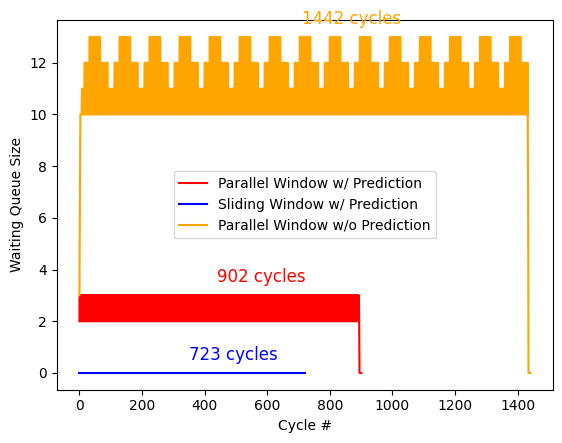

In [62]:
delay = 0
num_t_gen = 2
repeated_msd = []
for i in range(num_t_gen):
    repeated_msd += msd_op_list(i * 12 * (delay + 1), delay)

full_graph = compose_op_graphs(repeated_msd)
compute_dep_graph = di_dependency_graph(full_graph, schedule='parallel')
plot_3d_dep_graph(compute_dep_graph.di_dep_graph)
sim_and_plot(full_graph, t_w, delay, 1 * 100_000, num_blocking=num_t_gen*12)